In [1]:
import numpy as np
import torch, scipy

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
S = 2**16
RN = 32
Channel = 1
TS = 300

In [3]:
import os, pickle, Samp
'''
lat_var = Samp.generate_latent_var(S, 1, 2)
sam = Samp.generate_para_sample(RN, lat_var)
lat_var = Samp.generate_latent_var(TS, 3, 4)
Tsam = Samp.generate_para_sample(RN, lat_var)

if not os.path.exists(os.path.join(os.path.abspath('.'), 'KnownData')):
    os.mkdir(os.path.join(os.path.abspath('.'), 'KnownData'))
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'wb') as file:
    pickle.dump((sam, Tsam), file)
'''    
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'rb') as file:
    sam, Tsam = pickle.load(file)
sam = torch.from_numpy(sam).float()
Tsam = torch.from_numpy(Tsam).float() 

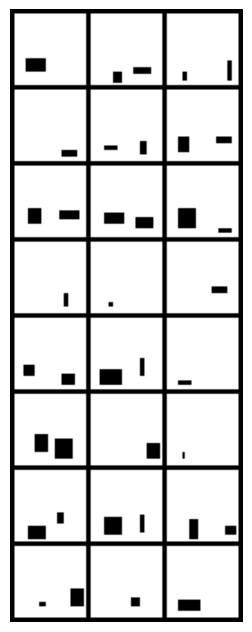

In [4]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Tsam = Tsam.clamp(0.0, 1.0)
%matplotlib inline
Tsam_grid = make_grid(1-Tsam[:24,...], nrow=(3))
plt.figure(figsize=(3,8))
plt.axis('off')
plt.imshow(Tsam_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'refsam_ve.jpg'), dpi=600, format='jpg')
plt.show()


In [5]:
import torch.nn as nn

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet32(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
            marginal_prob_std: A function that takes time t and gives the standard
              deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
            channels: The number of channels for feature maps of each resolution.
            embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, output_padding=1)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        
        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
  
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [6]:
import functools

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.  
    
    Returns:
        The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.
    
    Returns:
        The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
    
sigma =  25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [7]:
config = {  
            'n_epochs': 32, # number of training epochs
            'batch_size': 32, # size of a mini-batch
            'learning_rate': 1e-3, # learning rate
            'sample_step': 2000, # number of step for sampling
            'sample_batch_size': 64, # size of a batch for sampling 
            'ema_decay': 0.999, # decay rate for Exponential Moving Average 
            'lr_decay': 0.9,
            'lr_threshold': 1e-4,
            'lr_min': 5e-5
            }

In [8]:
class EMA():
    def __init__(self, parameters, mu, moving_mu=True):
        """
        Args:
            parameters: Iterable of 'torch.nn.Parameter'; usually the result of
                'model.parameters()'.
            mu: The exponential decay.
            moving_mu: Whether to a moving increase mu in the beginning of training
        """
        if mu < 0.0 or mu > 1.0:
            raise ValueError('Mu must be between 0 and 1')
        self.mu = mu
        self.num_updates = 0 if moving_mu else None
        self.shadow_params = [p.clone().detach()
                            for p in parameters if p.requires_grad]
        self.collected_params = []
        self.shadow = {}
        
    def update(self, parameters):
        """
        Update currently maintained parameters.

        Call this every time the parameters are updated, such as the result of
        the 'optimizer.step()' call.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; usually the same set of
                parameters used to initialize this object.
        """
        decay = self.mu
        if self.num_updates is not None:
            self.num_updates += 1
            decay = min(decay, (1 + self.num_updates) / (100 + self.num_updates))
        one_minus_decay = 1.0 - decay
        with torch.no_grad():
            parameters = [p for p in parameters if p.requires_grad]
            for s_param, param in zip(self.shadow_params, parameters):
                s_param.sub_(one_minus_decay * (s_param - param))
                
    def copy_to(self, parameters):
        """
        Copy current parameters into given collection of parameters.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                updated with the stored moving averages.
        """
        parameters = [p for p in parameters if p.requires_grad]
        for s_param, param in zip(self.shadow_params, parameters):
            if param.requires_grad:
                param.data.copy_(s_param.data)
                
    def store(self, parameters):
        """
        Save the current parameters for restoring later.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the 'store' method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        'copy_to' method. After validation (or model saving), use this to
        restore the former parameters.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)
        
    def state_dict(self):
        return dict(decay=self.decay, num_updates=self.num_updates,
                    shadow_params=self.shadow_params)

    def load_state_dict(self, state_dict):
        self.decay = state_dict['decay']
        self.num_updates = state_dict['num_updates']
        self.shadow_params = state_dict['shadow_params']


In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm.notebook import trange

class Score():
    def __init__(self, config, marginal_prob_std) -> None:
        self.marginal_prob_std=marginal_prob_std
        self.score = ScoreNet32(marginal_prob_std=self.marginal_prob_std).to(device)
        self.n_epochs = config['n_epochs']
        self.batch_size = config['batch_size']
        self.lr = config['learning_rate']
        self.ema = EMA(self.score.parameters(), mu=config['ema_decay'])
        self.config = config
    
    def count_parameters(self):
        return sum(p.numel() for p in self.score.parameters() if p.requires_grad)
    
    def loss_fn(self, x, eps=1e-5):
        """The loss function for training score-based generative models.

        Args:
            model: A PyTorch model instance that represents a 
            time-dependent score-based model.
            x: A mini-batch of training data.    
            marginal_prob_std: A function that gives the standard deviation of 
            the perturbation kernel.
            eps: A tolerance value for numerical stability.
        """
        random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
        z = torch.randn_like(x, device=device)
        std = self.marginal_prob_std(random_t)
        perturbed_x = x + z * std[:, None, None, None]
        score = self.score(perturbed_x, random_t)
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
        return loss

    def training(self, dataset):
        """The training function of the score network.

        Args:
            dataset: A dataset in TensorDataset format with both features and labels.
        """
        
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

        optimizer = Adam(self.score.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=self.config['lr_decay'], patience=200, 
                                      threshold=self.config['lr_threshold'], threshold_mode='rel', 
                                      cooldown=300, min_lr=self.config['lr_min'])
        tqdm_epoch = trange(self.n_epochs)
        
        self.score.train()
        for epoch in tqdm_epoch:
            avg_loss = 0.
            num_items = 0
            for x, _ in data_loader:
                x = torch.tensor(x, device=device) # x.to(device)    
                loss = self.loss_fn(x)
                optimizer.zero_grad()
                loss.backward()    
                optimizer.step()
                scheduler.step(loss)
                self.ema.update(self.score.parameters())
                #self.ema.copy_to(self.score.parameters())
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
            # Print the averaged training loss so far.
            tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
            # Update the checkpoint after each epoch of training.
            self.ema.restore(self.score.parameters())
            self.ema.copy_to(self.score.parameters())
            torch.save(self.score.state_dict(), 'ckpt_ve.pth')
        self.score.eval()

In [10]:
from torch.utils.data import TensorDataset

Score_Model = Score(config=config, marginal_prob_std=marginal_prob_std_fn)
dataset = TensorDataset(sam, torch.empty(sam.shape[0]))
#Score_Model.training(dataset)

In [11]:
num_steps = 2000#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        marginal_prob_std: A function that gives the standard deviation of
            the perturbation kernel.
        diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps. 
            Equivalent to the number of discretized time steps.
        device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.
    
    Returns:
        Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 32, 32, device=device) \
        * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    #with torch.no_grad():
    for time_step in time_steps:      
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        g = diffusion_coeff(batch_time_step)
        mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
        x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x

In [12]:
signal_to_noise_ratio = 0.1 #@param {'type':'number'}

## The number of sampling steps.
num_steps = 2000#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
            score_model: A PyTorch model that represents the time-dependent score-based model.
            marginal_prob_std: A function that gives the standard deviation
                of the perturbation kernel.
            diffusion_coeff: A function that gives the diffusion coefficient 
                of the SDE.
            batch_size: The number of samplers to generate by calling this function once.
            num_steps: The number of sampling steps. 
                Equivalent to the number of discretized time steps.    
            device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
            eps: The smallest time step for numerical stability.
    
    Returns: 
            Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, Channel, RN, RN, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    #with torch.no_grad():
    for time_step in time_steps:      
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        # Corrector step (Langevin MCMC)
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
        x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)   

        # Predictor step (Euler-Maruyama)
        g = diffusion_coeff(batch_time_step)
        x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
        x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [13]:
from tqdm.notebook import trange

class GDM():
    def __init__(self, config, marginal_prob_std, diffusion_coeff, sampler) -> None:
        """
        Args:
            sampler: ['Euler_Maruyama_sampler', 'pc_sampler']
        """
        self.sample_step = config['sample_step']
        self.s_n_batch = config['sample_batch_size']
        self.marginal_prob_std=marginal_prob_std
        self.diffusion_coeff = diffusion_coeff
        self.sampler = sampler
    
    def sampling(self, score_model, num_batch=1):
        """Generate a sample based on the score-based model

        Args:
            score_model: A score model. To sample the prior, use Score_NN.score.
            num_batch (int, optional): Number of batch to sample, output a sample size of 64*num_batch. Defaults to 1.

        Returns:
            Tensor: A sample with the size of (64*num_batch, Channel, resolution). Defaults to (64, 1, 32, 32)
        """
        samples = None
        tqdm_iter = trange(num_batch)
        for iter in tqdm_iter: 
            sample = self.sampler(score_model,
                                marginal_prob_std=self.marginal_prob_std,
                                diffusion_coeff=self.diffusion_coeff,
                                batch_size=self.s_n_batch,
                                num_steps = self.sample_step,
                                device=device)
            if samples is not None:
                samples = torch.cat((samples, sample), 0)
            else:
                samples = sample
        return samples
        

In [14]:
class FID():
    def __init__(self, ref_data, comp_data) -> None:
        self.eps = 1e-6
        self.orig_shape = ref_data.shape[1:]
        self.ref_data = ref_data.reshape((ref_data.shape[0], -1))
        self.comp_data = comp_data.reshape((comp_data.shape[0], -1))
        self.ref_mu = torch.mean(self.ref_data, dim=0).detach().cpu().numpy()
        self.comp_mu = torch.mean(self.comp_data, dim=0).detach().cpu().numpy()
        self.ref_sigma = torch.cov(self.ref_data.T).detach().cpu().numpy()
        self.comp_sigma = torch.cov(self.comp_data.T).detach().cpu().numpy()
        
    def calculate_frechet_distance(self):
        assert self.ref_mu.shape == self.comp_mu.shape, \
            'Training and test mean vectors have different lengths'
        assert self.ref_sigma.shape == self.comp_sigma.shape, \
            'Training and test covariances have different dimensions'
        
        diff = self.ref_mu - self.comp_mu

        # Product might be almost singular
        covmean, _ = scipy.linalg.sqrtm(self.ref_sigma.dot(self.comp_sigma), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % self.eps
            print(msg)
            offset = np.eye(self.ref_sigma[0]) * self.eps
            covmean = scipy.linalg.sqrtm((self.ref_sigma + offset).dot(self.comp_sigma + offset))
        
        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        self.FD = (diff.dot(diff) + np.trace(self.ref_sigma)
                + np.trace(self.comp_sigma) - 2 * tr_covmean)
        return self.FD
        
    def get_mean_cov(self):
        ref_mean = torch.tensor(self.ref_mu).reshape(self.orig_shape)[None, ...]
        comp_mean = torch.tensor(self.comp_mu).reshape(self.orig_shape)[None, ...]
        ref_cov = torch.tensor(self.ref_sigma)[None, None, ...]
        comp_cov = torch.tensor(self.comp_sigma)[None, None, ...]
        return ref_mean, comp_mean, ref_cov, comp_cov
 

In [15]:
gdm = GDM(config, marginal_prob_std_fn, diffusion_coeff_fn, pc_sampler)

In [16]:
def test_prior(N_test=100):
    ## Load the pre-trained checkpoint from disk.
    # device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
    ckpt = torch.load('ckpt_ve.pth', map_location=device)
    Score_Model.score.load_state_dict(ckpt)
    samples = gdm.sampling(Score_Model.score, N_test)

    with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam_ve' + '.pickle'), 'wb') as file:
        pickle.dump(samples.cpu(), file)

    from torchvision.utils import make_grid

    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samples[:24,...].clamp(0.0, 1.0), nrow=3)

    plt.figure(figsize=(3,8))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'compsam_ve.jpg'), dpi=600, format='jpg')
    plt.show()
    plt.close()
    
    fid = FID(sam, samples)
    ref_mean, comp_mean, ref_cov, comp_cov = fid.get_mean_cov()
    print(fid.calculate_frechet_distance())
    
    dsam = torch.sqrt((ref_mean - comp_mean)**2)
    samp = torch.cat((ref_mean, comp_mean, dsam), dim=0)
    scaler = torch.max(samp)
    samp /= scaler
    print(torch.max(dsam)/scaler)

    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samp, nrow=3)

    plt.figure(figsize=(9,3))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'mean_ve.jpg'), dpi=600, format='jpg')
    plt.show()
    plt.close()
    
    dsam_v = torch.sqrt((ref_cov - comp_cov)**2)
    samp_v = torch.cat((ref_cov, comp_cov, dsam_v), dim=0)
    scaler = torch.max(samp_v)
    print(scaler)
    samp_v *= 4
    print(torch.max(dsam_v)/scaler)
    print(torch.max(samp_v))

    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samp_v, nrow=3, padding=64)

    plt.figure(figsize=(9,3))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'cov_ve.jpg'), dpi=600, format='jpg')
    plt.show()
    plt.close()
    
    ref_std = torch.sqrt(torch.diag(ref_cov.squeeze()).reshape_as(ref_mean))
    comp_std = torch.sqrt(torch.diag(comp_cov.squeeze()).reshape_as(ref_mean))
    dsam_std = torch.sqrt(torch.diag(dsam_v.squeeze()).reshape_as(ref_mean))
    samp_std = torch.cat((ref_std, comp_std, dsam_std), dim=0)

    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samp_std, nrow=3)

    plt.figure(figsize=(9,3))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'std_ve.jpg'), dpi=600, format='jpg')
    plt.show()
    plt.close()
    return samples

In [17]:
snrFID = {'0.01': 6.28,
          '0.02': 5.96,
          '0.03': 5.56,
          '0.04': 5.35,
          '0.05': 5.15,
          '0.06': 5.03,
          '0.07': 4.88,
          '0.08': 4.81,
          '0.09': 4.75,
          '0.10': 4.69,
          '0.11': 4.74,
          '0.12': 4.82,
          '0.13': 4.81,
          '0.14': 4.79,
          '0.15': 4.77,
          '0.16': 4.83,
          '0.17': 4.88,
          '0.18': 4.94,
          '0.19': 4.90,
          '0.20': 4.87,
          '0.21': 4.89,
          '0.22': 4.91,
          '0.23': 4.98,
          '0.24': 4.98,
          '0.25': 4.99,
          '0.26': 5.05,
          '0.27': 5.05,
          '0.29': 5.17,
          '0.32': 5.12,
          '0.35': 5.17,
          '0.40': 5.47,
          '0.50': 6.47,
          '0.60': 8.41,
          '0.75': 17.73
          }

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\20195214\AppData\Local\Temp\ipykernel_15776\33147595.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
C:\Users\20195214\AppData\Local\Temp\ipykernel_15776\33147595.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


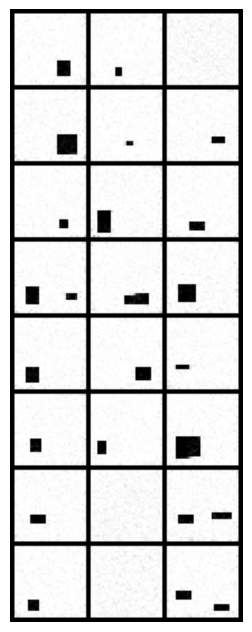

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.3057861328125
tensor(0.3431)


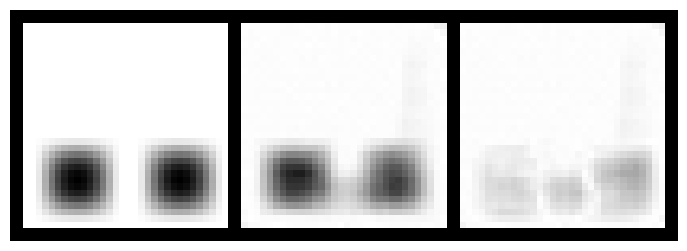

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2302)
tensor(0.3650)
tensor(0.9207)


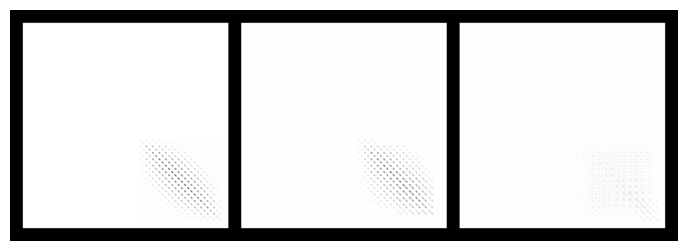

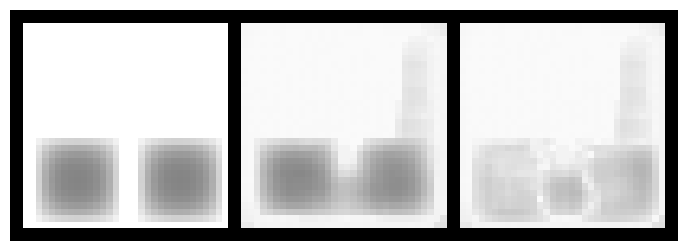

In [19]:
with torch.no_grad():
    pri_samples = test_prior(10)

In [143]:
import picnn

Forward_Model = picnn.Forward_Model
Forward_Model.load_para()

In [144]:
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'rb') as file:
    _, Tsam = pickle.load(file)

with open(os.path.join(os.path.abspath('.'), 'KnownData', 'UTSam' + '.pickle'), 'rb') as file:
    u_Tsam, obs_Tsam = pickle.load(file)
    
Tsam = torch.from_numpy(Tsam).float().to(device) 
obs_Tsam = torch.from_numpy(obs_Tsam).float() * 100

noise_level = [0.02, 0.04, 0.08, 0.16, 0.32, 0.64]
noise_fw = {'sem': 0.04, 'sup': 0.05}
obsnl = [0,3,6,9,18]
mode, noise_l, obn = 'sem', 0, 0
obsn = obsnl[obn]
obs_data = obs_Tsam + torch.randn(obs_Tsam.shape) * noise_level[noise_l] 
obs_data = obs_data.to(device)
obs_d = obs_data[obsn,...]

In [145]:

sigm = noise_level[noise_l]**2 + noise_fw[mode]**2
if mode == 'sem':
    Forward_Model.load_para()
elif mode == 'sup':
    Forward_Model.load_para_sup
ckpt = torch.load('ckpt_ve.pth', map_location=device)
Score_Model.score.load_state_dict(ckpt)
    
class Post_Score():
    def __init__(self, Forward_Model, Score_Model, sigm, marginal_prob_std_fn, obs_data) -> None:
        self.FW = Forward_Model.network
        self.obs = Forward_Model.obs
        self.Pri_Sco = Score_Model.score
        self.sigms = sigm
        self.obs_data = obs_data
        self.marginal_prob_std_fn = marginal_prob_std_fn
        self.FW.eval()
        self.Pri_Sco.eval()
    
    def cond_x0(self, x, time_step):
        a = 1.0
        b = self.marginal_prob_std_fn(time_step)**2
        x0t = a*(x + self.Pri_Sco(x, time_step)*b[:, None, None, None])
        return x0t
    
    def post_score(self, x, time_step):
        obs = self.obs_data.expand(x.shape[0], -1, -1)
        xt = x.clone().detach()
        xt.requires_grad_(True)
        x0t = self.cond_x0(xt, time_step)
        lss = torch.square(obs - self.obs(self.FW(x0t))).sum()
        lss.retain_grad()
        lss.backward()
        #print(lss)
        ls = xt.grad
        llh_score = -0.5 / (self.sigms) * ls
        llh_score.requires_grad_(False)
        with torch.no_grad():
            lr = 1.8/(config['sample_step']*time_step[0])
            pri_score = self.Pri_Sco(x, time_step)
            pscore = llh_score*lr + pri_score
            return pscore
        
post_score = Post_Score(Forward_Model, Score_Model, sigm, marginal_prob_std_fn, obs_d)

In [146]:
def seek_MAP(post_samples):
    with torch.no_grad():
        N_s = post_samples.shape[0]
        nb_dis = 15.
        N_nb = torch.zeros((N_s))
        for i in range(N_s):
            for j in range(i+1, N_s):
                if torch.square(post_samples[i,...] - post_samples[j,...]).sum() < nb_dis:
                    N_nb[i] += 1
                    N_nb[j] += 1
        ind = int(torch.argmax(N_nb).item())
        print(N_nb[ind])
        return post_samples[ind,...]
    
def seek_Mean_closet(post_samples, mean):
    with torch.no_grad():
        N_s = post_samples.shape[0]
        nearest = 100000.
        ind = 100000
        for i in range(N_s):
            disqu = torch.abs((mean - post_samples[i,...]).clamp(-0.2,1.0)).sum().item()
            if disqu < nearest:
                nearest = disqu
                ind = i
        return post_samples[ind,...]
    
def seek_MLL(post_samples):
    with torch.no_grad():
        obs = obs_data[obsn,...]
        s = post_samples.shape[0]
        lss = torch.square(obs.expand(s, -1, -1) - Forward_Model.obs(Forward_Model.network(post_samples)))
        llh = torch.sum(lss, dim=(1,2))
        ind = int(torch.argmin(llh).item())
        print(llh[ind])
        return post_samples[ind,...]
    

In [147]:
def test_samp_post(N_test=10):
    ## Load the pre-trained checkpoint from disk.
    # device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
    p_samples = gdm.sampling(post_score.post_score, N_test).clamp(0.0, 1.0)
    with torch.no_grad():
        p_sam = None
        for i in p_samples:
            if torch.square(i).sum() > 6.0 or torch.max(i) > 0.6:
                if p_sam is not None:
                    p_sam = torch.cat((p_sam, i[None,...]), dim=0)
                else:        
                    p_sam = i[None,...]
        return p_sam
    
def plot_post(post_samples):

    from torchvision.utils import make_grid

    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-post_samples[:64,...].clamp(0.0, 1.0), nrow=8)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    # plt.savefig('postsam_ve.eps', format='eps')
    plt.show()
    
    cov = torch.cov(post_samples.reshape((post_samples.shape[0], -1)).T)
    mean = torch.mean(post_samples, 0)
    MAP = seek_MAP(post_samples)
    Mc = seek_Mean_closet(post_samples, mean)
    Mlh = seek_MLL(post_samples) 
    stdv = torch.sqrt(torch.diag(cov).reshape_as(Mlh))
    #dsam = torch.sqrt((Mlh - Tsam[obsn,...])**2)
    
    samp = torch.cat((Tsam[obsn,...], Mlh, Mc, MAP, mean, stdv), dim=0)[:6, None,...]
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samp, nrow=6)
    plt.figure(figsize=(24, 4))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'post_others', 'ot_post_ve_%d_%d.jpg'%(noise_l, obsn)), dpi=600, format='jpg')
    plt.show()
    
    cov = cov[None, None, ...]
    samp_v = torch.cat((cov, cov), dim=0)
    scaler = torch.max(samp_v)
    print(scaler)
    samp_v *= 4
    sample_grid = make_grid(1-samp_v, nrow=2, padding=64)
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'post_others', 'ot_postcov_ve_%d_%d.jpg'%(noise_l, obsn)), dpi=600, format='jpg')
    plt.show()
    
def plot_post_sim(post_samples):

    from torchvision.utils import make_grid

    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-post_samples[:64,...].clamp(0.0, 1.0), nrow=8)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    # plt.savefig('postsam_ve.eps', format='eps')
    plt.show()
    
    mean = torch.mean(post_samples, 0)
        
    Mlh = seek_MLL(post_samples)
    samp = torch.cat((Tsam[obsn,...], Mlh, mean), dim=0)[:3, None,...]
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(1-samp, nrow=3)
    plt.figure(figsize=(12,4))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'post', 'post_ve_%d_%d.jpg'%(noise_l, obsn)), dpi=600, format='jpg')
    plt.show()
    plt.close()

In [148]:
post_samples = test_samp_post(4)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_2682/33147595.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_2682/33147595.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


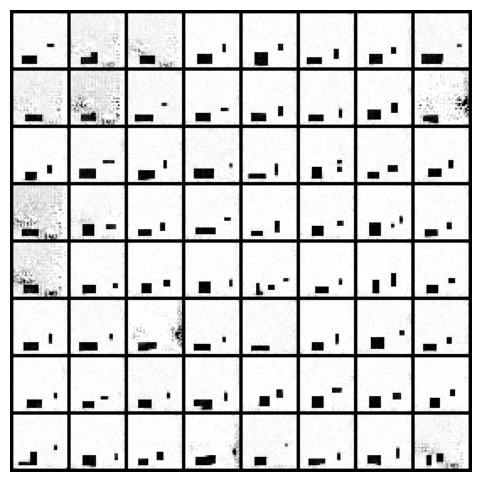

tensor(21.)
tensor(0.6149, device='cuda:0')


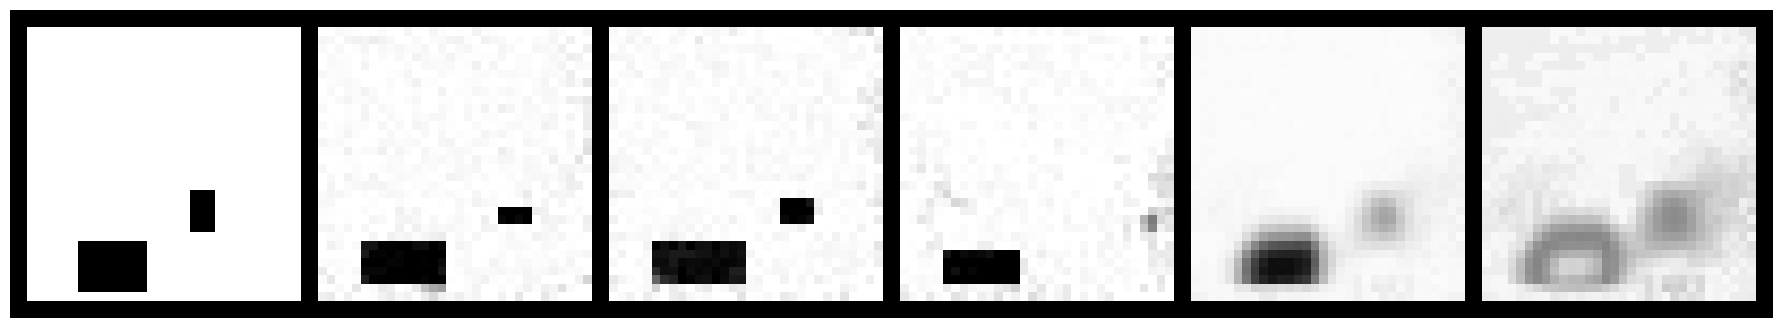

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2256, device='cuda:0')


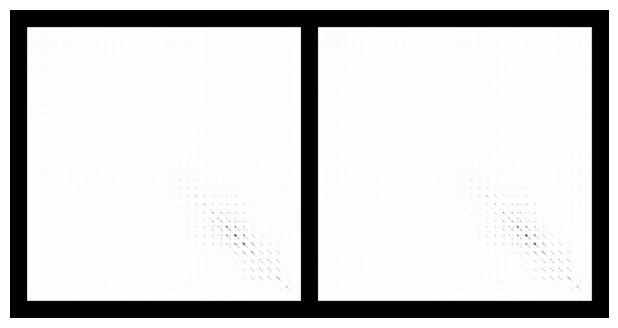

In [149]:
# plot_post_sim(post_samples)
plot_post(post_samples)